# 1D window tracking

Continuing with the image differentiation, wherein we set the premise for edge detection and motion analysis, we will study in detail on how to implement those ideas in practice. 

Motion analysis is an important technique in which image sequences, like video are analyzed to understand motion between the images. It can be simple application of finding if the object in the image frames are moving and more complex application would be to detect motion of a specific object across the frames. It has possibilities of application in manufacturing, healthcare, satellite imaging, etc. 

Before making computers understand how to detect motion, let's go over how our brain detects motion.

Our brain perceives objects in motion as the objects move across sensors in our eyes[2]. After being observed by our eyes, our brain compares consecutive video frames to make inferences about the motion. This is similar to detecting motion where the intensity of light incident on the sensors changes rapidly. 

There are variety of applications of motion detection namely tracking, video compression, alignment, motion based segmentation, etc. 

A video is nothing but a sequence of frames captured over time. In one dimension, image data is a function of location (x) and time (t). We have already gone over one of the simplest ways to detect motion: image differentiation, we will go over the next method which is based on *optical flow*.

Optical flow is when we fix on a single point and measure velocity flowing through that particular point. It assumes that image intensity is constant over a infinitesimal time period $\Delta t$. 

Using this, we get the Brightness Change Constraint Equation (BCCE).

$$ \frac{\partial e}{\partial x} \frac{dx}{dt} + \frac{\partial e}{\partial t} =0 $$

We can utilize this to detect motion. 

## Window Tracking in general

Before we dive into particular details of algorithm *Lucas Kanade tracker*, let's understand the basics behind window tracking and how it is done in 1D.

For two grayscale images f(x) and g(x), of same scene from different points of view, e imagine a small window W($x_{f}$), of length 2h+1 centered at $x_{f}$ in f , so we have to find 

$$ x_{g} = x_{f} + d^{*} (x_{f}) $$

This denotes the corresponding center on Window in the image g(x). 

$d^{*} (x_{f})$ is the displacement of the point feature. 

To find the optimum value of displacement, $d^{*} (x_{f})$, we measure the residual 

$$ L(x_{f},d) = \sum_{x} [g(x+d)-f(x)]^{2} \ w(x-x_{f})$$

here, w(x) is the indicator function of window W(0)


$$  d^{*} (x_{f}) = argmin L(x_{f},d) $$ which is operated over a search range, a square centered at the origin of the plane.

The underlying assumption is that motion in window W($x_{f}$) is constant. In general, which might not be always true so the indicator function used for W($x_{f}$) is used as trunctaed Gaussian.

One of the ways to optimize the the loss function is to go for an exhaustive grid search but it is comptutional expensive. 

We have Lucas Kanade way of optimising it using the assumption that velocity vector is constant within a small neighbourhood. 

## A very simple representation of point tracking in 1D

Because this notebook focussed on 1D, let's see a very simple implementation of window tracking (point tracking in 1D) and understand the concept better.

Let's say we have two curves 

f(x)=sinx
g(x)=sin(x+0.3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

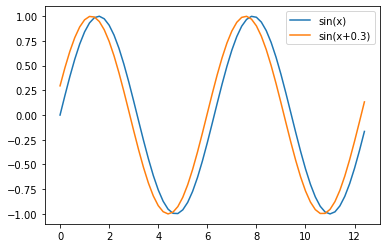

In [2]:
x=np.arange(0,4*np.pi,0.2)
f_x=np.sin(x)
g_x=np.sin(x+0.3)
g_prime_x=np.gradient(g_x)


plt.plot(x,f_x)
plt.plot(x,g_x)
plt.legend(['sin(x)', 'sin(x+0.3)'])
plt.show()

In the curve above, we know that the second curve, g(x) is shifted by 0.3.

what if we did not know that and we just had these two images f(x) and g(x) which are images of same scene from different view points and we wanted to calculate displacment between them?

To enable that, we will create a simple 1D point tracker. 

So we have two images f(x) and g(x+h)

At any point x, the loss function discussed above will be 

$$L(d)= [g(x+h)-f(x)]^{2}$$

$$L(d)\approx [g(x)+ hg'(x)-f(x)]^{2}$$ using Taylor series expansion

Differentiating and setting it equal to zero, we can calculate the value of h as being approximately 

$$h \approx \frac{g(x)-f(x)}{-g'(x)}$$

In [3]:
def derivative(f,a,method='central',h=0.01):
        return (f(a + h) - f(a - h))/(2*h)

In [4]:
def f(x):
    return np.sin(x)

In [5]:
def g(x):
    return np.sin(x+0.3)

In [6]:
x=7
f_x=f(x)
g_x=g(x)
g_prime_x=derivative(np.sin,x)

h=(g_x-f_x)/g_prime_x
h

0.25660255689636835

Which is close to our original shifted value, 0.3. We are doing approximation here and a very simple implementation, therefore we do not have an exact number. 

This was a simple demonstration of 1D point tracking. Let's move to Lucas Kanade tracker in 1d

## Lucas Kanade tracker in 1D

With underlying assumptions that:

<li> Velocity vector is constant within a small neighbourhood </li>
<li> The motion is small within the windown </li>

We can attempt at creating a Lucas Kanade tracker in 1D. 

Before that, let's go over optical flow in 1D.

For an image's irradiance e(x,t), at a point p,

Temporal derivative, will be 
$$ e_{t}= \frac{\partial e}{\partial t} $$ and spatial derivative will be $$ e_{x}=\frac{\partial e}{\partial x} $$

Using the BCCE equation, 

$$ \frac{\partial e}{\partial x} \frac{dx}{dt} + \frac{\partial e}{\partial t} =0 $$

$$ u \nabla= - \frac{e_{t}}{e_{x}} $$

We will keep calculating $u \nabla$ which is the incremental displacement and  terminate where either norm $u\nabla$ or L($d^{*}$) is too large. 

To ensure that, we start at some initial point $u_{0}$  

The overall displacement will be sum of displacement at each step 

## Lucas Kanade tracker in Python

This is an interative process, so we will try to build upon the simplified point tracker that we had built in the last section. 

Our functions are the same

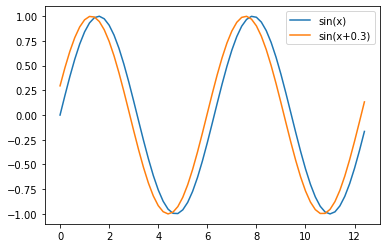

In [7]:
x=np.arange(0,4*np.pi,0.2)
f_x=np.sin(x)
g_x=np.sin(x+0.3)
g_prime_x=np.gradient(g_x)

plt.plot(x,f_x)
plt.plot(x,g_x)
plt.legend(['sin(x)', 'sin(x+0.3)'])
plt.show()

We can calculate the value of $e_{x}$ using the differentiation formula with central difference formula.

In [8]:
def derivative(f,a,method='central',h=0.01):
        return (f(a + h) - f(a - h))/(2*h)

In [9]:
e_x=derivative(np.sin,7) #we can keep using this value later on
e_x

0.7538896893685365

Now, at each step, we will calculate $I_{t}$ which the difference between $g_{x}$ and $f_{x}$ and the values we find out for $u\nabla$, we will update the function $g_{x}$ as $g_{x+u}$ and keep the process continued till we notice that the norm of $u\nabla$ is very large and we will terminate optimization there. 

The overall displacement will the be sum of incremental displacement till that step. 

The implementation is very discrete here and can be converted into a function, which has been done later on!

In [10]:
x=7
g_x=g(7)
f_x=f(7)

In [11]:
#function that returns total displacement by comparing two images

def lucas_kanade(fx,gx,ex,x,delta,epsilon):
    """
    Applies Lucas Kanade window tracking method in 1D under 
    the assumption of BCCE and small motion at that point. 
    The function returns the total displacement at a particular
    value. 
    
    Parameters
    ----------
    fx: ndarray
        reference image
    gx:ndarray
        displaced image to be compared against
        reference image 
    x: integer
        local value 
    delta: float
        threshold for each step value
    epsilon: float
        threshold to compare loss function
    
    
    Returns
    -------
    sum(del_u) : float
        total_displacement
    
    
    """
    #creating an empty array to store incremental displacement
    del_u=[]
    x=x
    #temporal derivative
    e_t=gx-fx
    #incremental derivative
    del_u_initial=-e_t/ex
    #initial and updated loss function values
    L_initial=e_t**2
    L_updated=0
    #applying the thresholds for convergence
    while abs(del_u_initial)>delta and L_initial-L_updated>epsilon:
        e_t=gx-fx 
        L_initial=e_t**2
        del_u_temp=-e_t/ex
        del_u.append(del_u_temp)
        gx=g(x+del_u_temp)
        del_u_initial=del_u_temp
        L_updated=(gx-fx)**2
        
    return sum(del_u)

In [12]:
displacement=lucas_kanade(f_x,g_x,e_x,7,0.00001,0.00001)
displacement

-0.2991666018736986

The value of local displacement at x=7 is very close to the original displacement. The value is negative, however because the direction of displacement here is assumed to be from the displaced image to the original image, rather than from original to displaced image. 

References:

1. Duke University, CS 527, Spring 22: https://courses.cs.duke.edu//spring22/compsci527/notes/n_07_image_motion.pdf
2. University of Central Florida CAP5415: http://www.cs.ucf.edu/~bagci/teaching/computervision17/Lec7.pdf 
3. University of Zurich lecture on Tracking, 2015: https://files.ifi.uzh.ch/rpg/teaching/2015/11_tracking.pdf
4. Clemenson University, ECE 847 Fall 2005: https://cecas.clemson.edu/~stb/ece847/internal/lectures/lecture06-motion.ppt